<a href="https://colab.research.google.com/github/Geological-Survey-Ireland/Hyperspectral/blob/main/3_Removing_the_core_box_from_the_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Removing the core box from the image**

Notebooks [1](https://github.com/Geological-Survey-Ireland/Hyperspectral/blob/main/1_Opening_and_Starting_with_GSI_Hyperpectral_Data.ipynb) and [2](https://github.com/Geological-Survey-Ireland/Hyperspectral/blob/main/2_Denoising_GSI_Hyperspectral_Data.ipynb) are pre-requisites for using this notebook, as we will be using data generated in those notebooks.

This process is for removing the corebox from the image and working with the data in depth in metres instead of pixel number.

This process is much easier to do in a IDE rather than a notebook, as reading pixel coordinates is easier in a tkinter pop out widow. This notebook is for illustration. 

Again the first thing is to import all of the modules we will need:



In [1]:
!pip install spectral

import spectral as sp
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 200

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 3.9 MB/s eta 0:00:00


Now we need to open the de-noised, reflectance data created in the first two notebooks.

(1834, 384, 249)


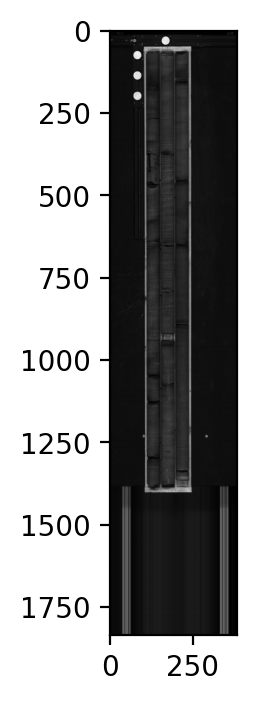

In [2]:
# Use numpy to load the denoised data calculated in notebook 1.
data = np.load('/content/drive/MyDrive/Public/One_PC_denoised.npy')
# Use the spectral python imshow wrapper to display the core box
view = sp.imshow(data)
# Print the array shape of the data
print(data.shape)

We can see from the data shape that the image is 1834 pixel long and 384 pixels wide. The majority of those pixels are either the scanning table or the core-box. 

We need to separate the pixels that represent the drill core from everything else.

We also know that the corebox has three runs which all have downhole downwards in the image.

In the pop out image generated in an IDE pixel coordinates can be read off, then the image can be sliced using [numpy slicing](https://numpy.org/doc/stable/user/basics.indexing.html#index-0).

The first core pixel on the left is at 114 and the last for pixel on the right is at 230.

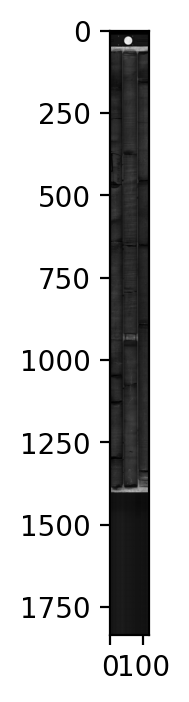

In [3]:
# Use numpy indexing to slice the 2nd axis of the array
slice1 = data[:, 114:230]
# Use the spectral python imshow wrapper to view the sliced dataset
view = sp.imshow(slice1)

This first slice has removed all of the pixels to the right and left of the core itself, now we need slice the top and bottom.

It can be seen in the image that the first and last position of the core pixel is different for each run. So, before we can do the top and bottom slices, we need to separate each run into new numpy arrays.

Each run needs to have the same width as we will want to concatenate them at the end.

The run left-right pixel indexes are:

run 1: 200 - 230

run 2: 156 - 186

run 3: 200 - 230


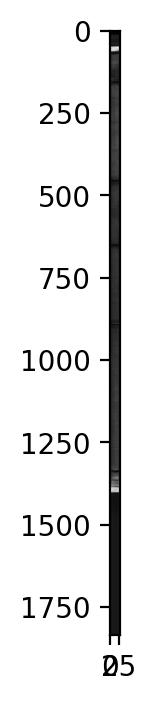

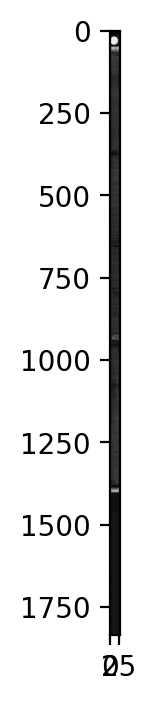

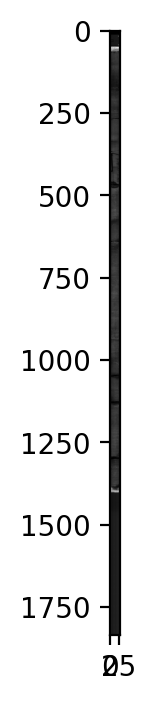

In [4]:
# Use numpy indexing to slice the second axis of the dataset
run1 = data[:, 200:230]
# Use numpy indexing to slice the second axis of the dataset
run2 = data[:, 156:186]
# Use numpy indexing to slice the second axis of the dataset
run3 = data[:, 114:144]
# Use the spectral python imshow wrapper to view the sliced dataset
view1 = sp.imshow(run1)
view2 = sp.imshow(run2)
view3 = sp.imshow(run3)

So, we now have our three runs neatly clipped to left and right, but be need to slice the top and bottom, and remove the core markers from the image.
The top bottom indexes for the runs are:

run1: 72 - 1363

run2 (above core-marker): 67 - 915

run2 (below core-marker): 941 - 1375

run3 (above core-marker): 68 - 1288

run3 (below core-marker): 1302 - 1377

(1291, 30, 249) (1282, 30, 249) (1295, 30, 249)
3868


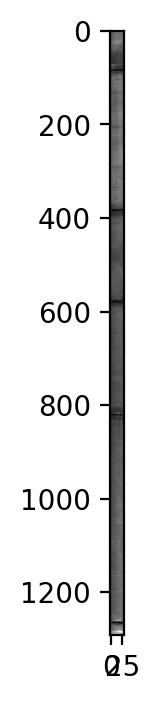

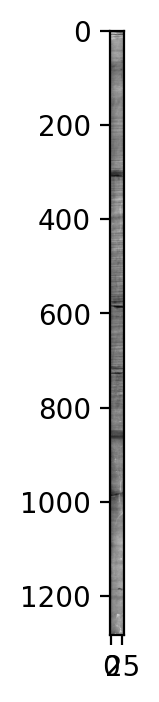

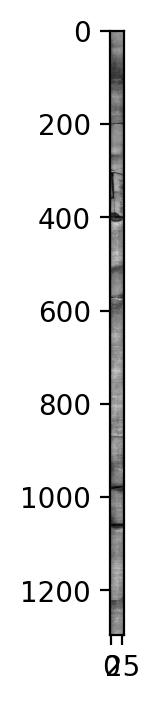

In [5]:
# Use numpy indexing to slice the first axis of the dataset
run1 = run1[72:1363, :]
run2a = run2[67:915, :]
run2b = run2[941:1375, :]
run3a = run3[68:1288, :]
run3b = run3[1302:1377, :]

# We need to stitch the arrays above and below the core marker into single arrays.
# the np.concatenate function will join the arrays where the axis shapes match.
run2 = np.concatenate((run2a, run2b))
run3 = np.concatenate((run3a, run3b))
# Print the data shape of the three new arrays and print their combined y-axis length
print(run1.shape, run2.shape, run3.shape)
print(run1.shape[0] + run2.shape[0] + run3.shape[0])
# Use the spectral python imshow wrapper to view the sliced datasets
view1 = sp.imshow(run1)
view2 = sp.imshow(run2)
view3 = sp.imshow(run3)

So now we have removed all the pixels that are not core, we can stitch them together into a continuous length.

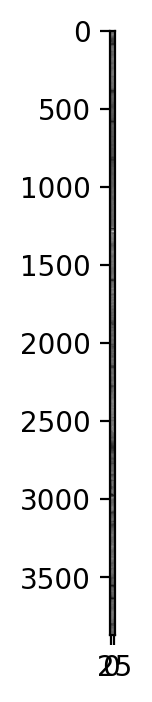

In [6]:
# Stitch together the three arrays into a single downhole dataset
# using numpy concatenate
length = np.concatenate((run1, run2, run3))
# Use the spectral python imshow wrapper to view the sliced dataset
view = sp.imshow(length)
# Save the core-length to disk using numpy
np.save('/content/drive/MyDrive/Public/SampleData_length.npy', length)

Now we can plot a single wavelength down the hole.

The graph below shows the variation in the value of a single band, band 230, for a single pixel down the centre of the length of the core.

<function matplotlib.pyplot.show(*args, **kw)>

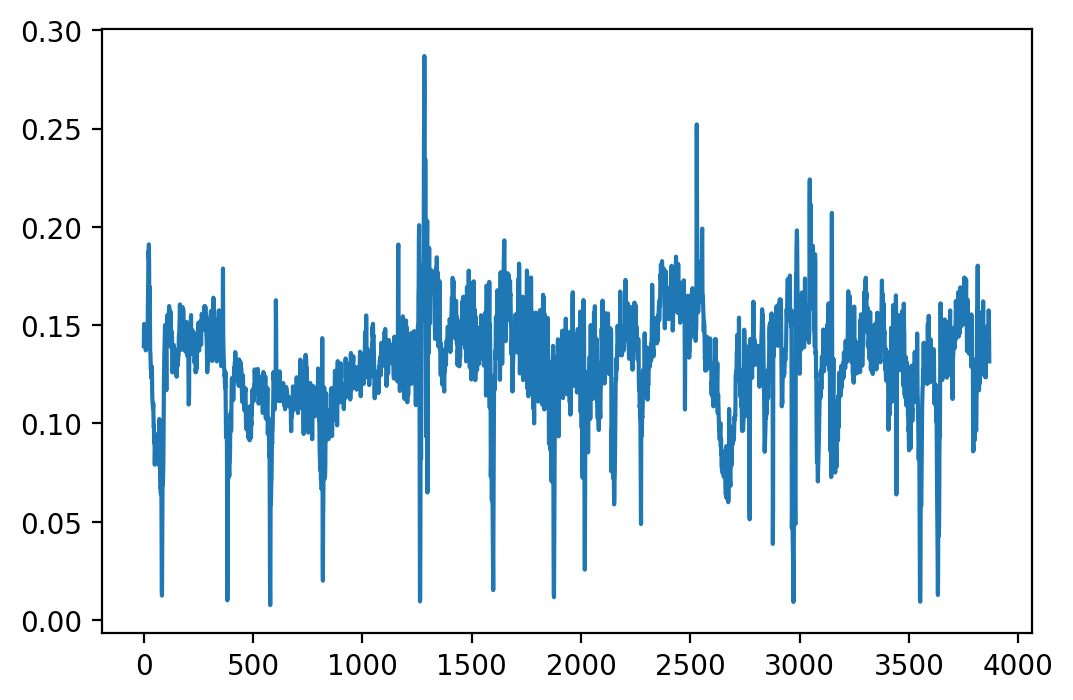

In [7]:
# Use matplotlib to plot a line down the centre of the x-axis of our dataset
# this slice uses all of the first axis, index 15 of the second axis and index
# 230 of the third axis
plt.figure()
plt.plot(length[:, 15, 230])
plt.show

So the x- axis on the chart above is pixel number, while the y-axis is the reflectance value.

But we know the depth at the top of the core, we know the depth at the base of the corebox, and we know how many pixels represent the difference.

With this we can calculate the depth in m per pixel.

In [8]:
# Assign depth at top of core to a variable
top_depth = 101.57 #depth in m from core-box
# Assign depth at bottom of core to a variable
bottom_depth = 105.98 #depth in m from core-box
# Assign the number of pixels between known depths to a variable
pixel_length = length.shape[0]
# Calculate the length in m of a single pixel
pixel_per_m = (bottom_depth - top_depth) / pixel_length
# Iterate through the number of pixels on the y-axis, calculating the 
# depth in m for each pixel from the start of the core.
# Assign each value in order to the list named depth
depth = []
for i in range(length.shape[0]):
  depth.append((i * pixel_per_m) + top_depth )
# Print the length of the depth list, to sure it is the same 
# length as the data y-axis
print(len(depth))

3868


In [ ]:
print(pixel_per_m)

0.00114012409513961


So with these lines of code you can see that we have created a list with the same length as the number of pixels in our data, and each value in the list is equal to the depth in metres starting at the top of the box.

Now we can plot our graph again, but with metres on the x-axis

<function matplotlib.pyplot.show(*args, **kw)>

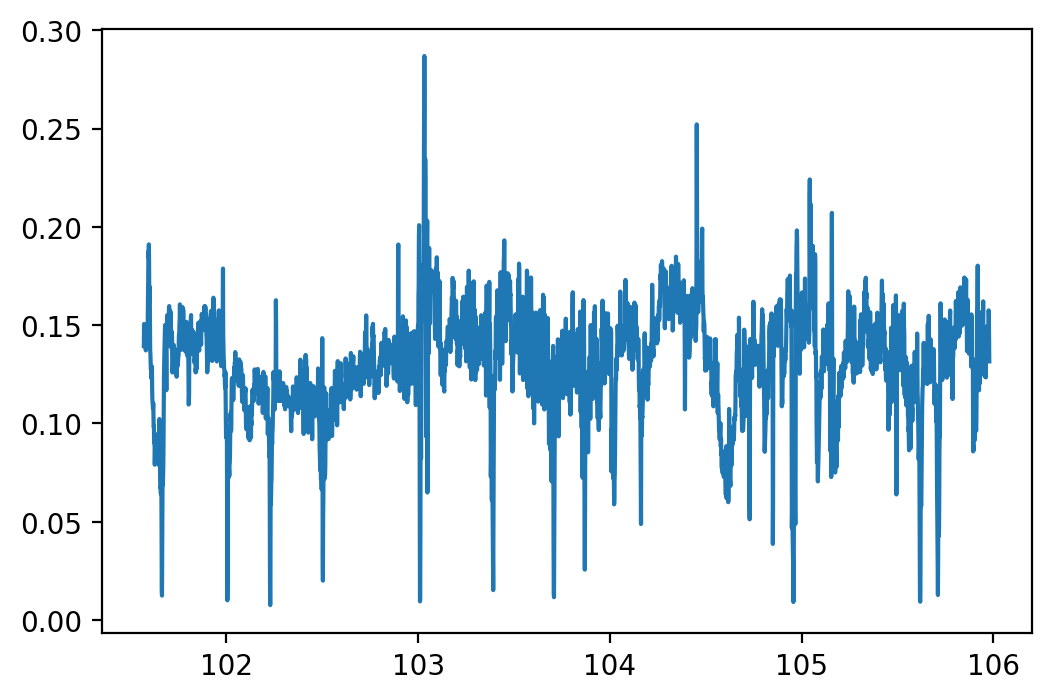

In [9]:
# Use matplot lib to plot a line downhole of a sing refelctance wavelength
# against depth
plt.figure()
plt.plot(depth, length[:, 15, 230])
plt.show

So we can now plot features from our drillhole against depth, but we can add more code to make it look more like a downhole plot.

This time we plot depth on the y-axis and values on the x-axis, and we set the axis limits so that the depth increases downwards:

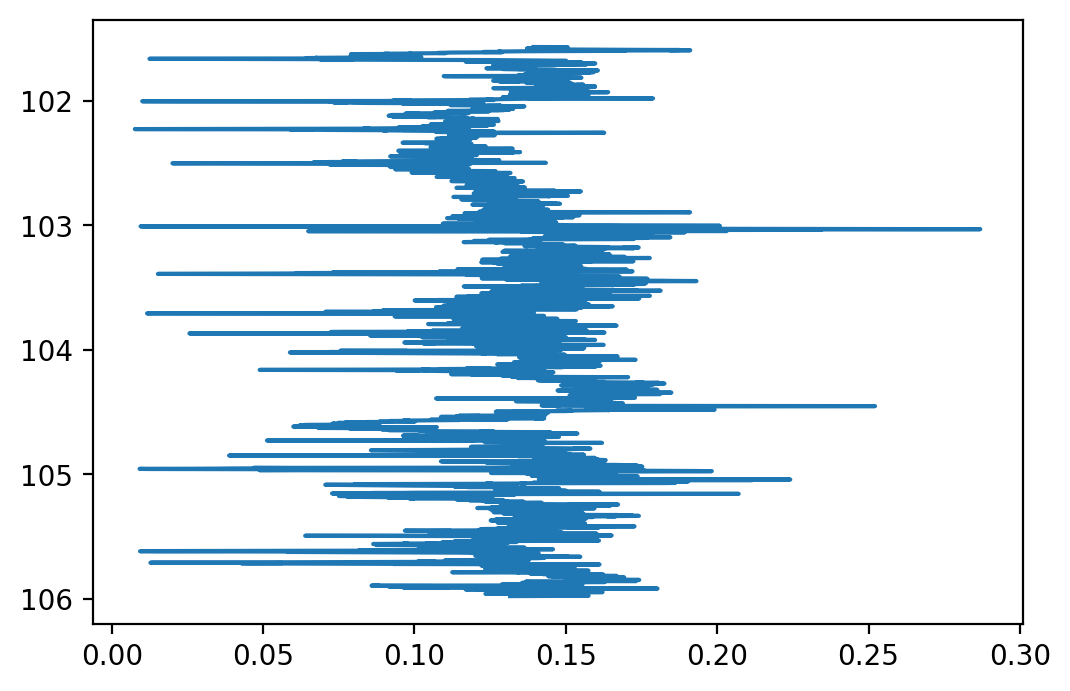

In [10]:
# Use matplot lib to plot a line downhole of a sing refelctance wavelength
# against depth, such that depth is represented on the y-axis as downhole.

plt.figure()
plt.plot(length[:, 15, 230], depth)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
